In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd drive/MyDrive/Colab Notebooks/markov-language-model
sys.path.append('/content/drive/MyDrive/Colab Notebooks/markov-language-model')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/markov-language-model


In [160]:
import numpy as np
import pandas as pd
from markovmodel import MarkovModel
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, f1_score

In [187]:
data = pd.read_csv('victorian-authors.csv')
data.head() , data.tail()

(                                                text  author
 0  ou have time to listen i will give you the ent...       1
 1  wish for solitude he was twenty years of age a...       1
 2  and the skirt blew in perfect freedom about th...       1
 3  of san and the rows of shops opposite impresse...       1
 4  an hour s walk was as tiresome as three in a s...       1,
                                                     text  author
 17820  a sudden flash of lightning he could not at on...      15
 17821  not leave her room and at the end of the week ...      15
 17822  happened after she left them dry your eyes the...      15
 17823  again no doubt mrs forest said turning to mrs ...      15
 17824  well i hope we shall be able to conquer death ...      15)

In [188]:
no_of_authors = 5

# randomly sample required number of authors
author_list = data['author'].sample(no_of_authors, replace=False).values

# extract the texts by these randomly chosen authors
bool_mask = data['author'].isin(author_list)
data = data[bool_mask]
data.head(), data.tail()

(                                                   text  author
 3397  t is only the railroad the arches of the railr...       8
 3398  partially enveloped the seed ned the same kind...       8
 3399  king s sake how gladly we repeat it sailing on...       8
 3400  why is this we shall soon see we push through ...       8
 3401  bear don t cry so loud bony is not here she to...       8,
                                                     text  author
 13179  rather as it afterward proved you would have r...      12
 13180  had escaped death was not s fault and the dead...      12
 13181  himself in the wrong box i can tell you you ve...      12
 13182  blame surely your father will give you half th...      12
 13183  liar you are a liar he screamed white a final ...      12)

In [189]:
counts = data['author'].value_counts()
counts

8     6914
9     1108
12     627
11     383
Name: author, dtype: int64

In [190]:
# find the class smallest number of texts
no_to_sample = counts.min()
sampled_list = []

# sample this number of texts from each
# author to ensure a balanced dataset
for i in counts.index:
  sampled_list.append( (data[ data['author'] == i]).sample(no_to_sample) )

data = pd.concat(sampled_list)
data.head(), data.tail()

(                                                   text  author
 5083  saw a light in all the house if i had been a c...       8
 9476  you say so b pays the highest lawful interest ...       8
 8409  will be a short one i was afraid said to see h...       8
 8609  the man in whose preservation i was so much co...       8
 3522  himself with an energy that made his eyes star...       8,
                                                     text  author
 12538  into the hands of the the custom was capable o...      11
 12397  as he passed into the stock â by the water gat...      11
 12441  from the natives by purchase or by treaty of s...      11
 12447  of religious freedom consideration to stir him...      11
 12417  be to the joint stock and system of labor and ...      11)

In [195]:
x_train, x_test, y_train, y_test = tts(data['text'], data['author'], test_size=0.2)

# combining the data & label for the training set
# simplifies the extraction of the text into a single
# string for each author in the cell below

train_data = pd.concat((x_train,y_train), axis = 1)

In [156]:
# model parameters

n = 5
alpha = 0.001

model_list = []

for author in train_data['author'].unique():
  training_string = str()

  for text in train_data[ train_data['author'] == author]['text']:
    training_string += ' ' + text + ' '

  model_list.append( MarkovModel(training_string, n, alpha) )


In [158]:
y_hat = []

for test_string in x_test:
  log_probs = []

  # for each text sample in the test set obtain the
  # log probability score returned by each model

  for model in model_list:
    log_probs.append( model.predict(test_string) )

  log_probs = np.array(log_probs)
  prediction_arg = log_probs.argmax()

  # the arg_max gives us the index position of the 'winning'
  # model in model_list. We want the actual author label. This
  # is the value at the corresponding position in counts.index

  y_hat.append( counts.index[ prediction_arg ] )

In [228]:
print (f'Accuracy {f1_score(y_hat, y_test, average="micro")}' )
print (f'Macro F1 {f1_score(y_hat, y_test, average="macro")}' )

Accuracy 0.511400651465798
Macro F1 0.5043365376680862


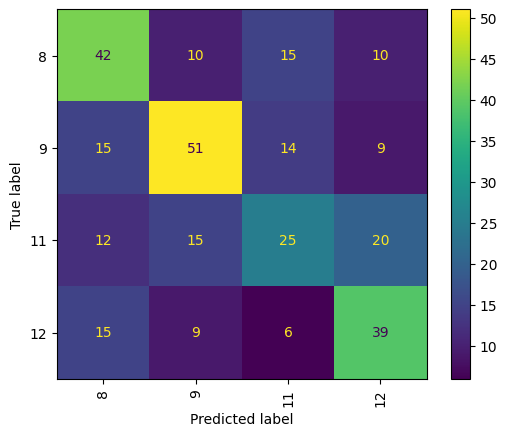

In [229]:
labels = np.sort( y_test.unique() )
confusion_plot = ConfusionMatrixDisplay( confusion_matrix(y_test, y_hat), display_labels = labels)
confusion_plot.plot(xticks_rotation=90);